In [1]:
import torch
import torch.nn.functional as F
import random
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import skimage.io
import skimage.color
import skimage.filters
import skimage.exposure
from skimage import feature, measure
from skimage.draw import line
from skimage.transform import probabilistic_hough_line
from scipy.spatial import distance
from scipy.ndimage import convolve
from scipy.signal import convolve2d

import time
import math

import cv2


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#testing with sample image to see if indeed we get potential vanishing points

In [2]:
image = skimage.io.imread("image.jpg")

In [3]:

'''from skimage import io, color, feature
import matplotlib.pyplot as plt



# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Apply Canny edge detection
edges = feature.canny(gray_image, sigma=2.0)

# Find contours
contours = measure.find_contours(edges, 0.8)

# Create a copy of the image to draw lines on
image_with_lines = image.copy()

# Draw the detected lines on the image
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], '-r', linewidth=2)

# Display the resulting image with detected lines
plt.imshow(image_with_lines)
plt.show()'''

"from skimage import io, color, feature\nimport matplotlib.pyplot as plt\n\n\n\n# Convert the image to grayscale\ngray_image = color.rgb2gray(image)\n\n# Apply Canny edge detection\nedges = feature.canny(gray_image, sigma=2.0)\n\n# Find contours\ncontours = measure.find_contours(edges, 0.8)\n\n# Create a copy of the image to draw lines on\nimage_with_lines = image.copy()\n\n# Draw the detected lines on the image\nfor contour in contours:\n    plt.plot(contour[:, 1], contour[:, 0], '-r', linewidth=2)\n\n# Display the resulting image with detected lines\nplt.imshow(image_with_lines)\nplt.show()"

Testing using Hough transform

In [4]:
'''import cv2
import numpy as np
from skimage import feature
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Edge detection using skimage
edges = feature.canny(gray, sigma=3)

# Line detection using Hough Transform in skimage
h, theta, d = hough_line(edges)

# Find peaks in the Hough space to get lines
peaks = hough_line_peaks(h, theta, d, threshold=0.5 * h.max())

# Filter and draw the lines
for _, angle, dist in zip(*peaks):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - gray.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, gray.shape[1]), (y0, y1), '-r')



plt.imshow(image)
plt.show()'''


'import cv2\nimport numpy as np\nfrom skimage import feature\nfrom skimage.transform import hough_line, hough_line_peaks\nimport matplotlib.pyplot as plt\n\n# Load an image\nimage = cv2.imread("image.jpg")\ngray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n\n# Edge detection using skimage\nedges = feature.canny(gray, sigma=3)\n\n# Line detection using Hough Transform in skimage\nh, theta, d = hough_line(edges)\n\n# Find peaks in the Hough space to get lines\npeaks = hough_line_peaks(h, theta, d, threshold=0.5 * h.max())\n\n# Filter and draw the lines\nfor _, angle, dist in zip(*peaks):\n    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)\n    y1 = (dist - gray.shape[1] * np.cos(angle)) / np.sin(angle)\n    plt.plot((0, gray.shape[1]), (y0, y1), \'-r\')\n\n\n\nplt.imshow(image)\nplt.show()'

Tried gaussian transform but turns out too computationally intensive for google colab

In [5]:
#too computationally intensive
'''
import cv2
import numpy as np
from skimage.feature import corner_harris, corner_peaks
from skimage.draw import line
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Laplacian of Gaussian (LoG) for edge detection
edges = cv2.Laplacian(gray, cv2.CV_64F)
edges = cv2.convertScaleAbs(edges)

# Find Harris corners
coords = corner_peaks(corner_harris(edges), min_distance=5)

# Detect lines connecting the corners
lines = []
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        start_point = tuple(map(int, coords[i]))
        end_point = tuple(map(int, coords[j]))

        rr, cc = line(start_point[0], start_point[1], end_point[0], end_point[1])
        line_coords = list(zip(rr, cc))
        lines.append(line_coords)

# Draw the detected lines
for line_coords in lines:
    for x, y in line_coords:
        image[y, x] = [0, 0, 255]

plt.imshow(image)
plt.show()
'''

'\nimport cv2\nimport numpy as np\nfrom skimage.feature import corner_harris, corner_peaks\nfrom skimage.draw import line\nimport matplotlib.pyplot as plt\n\n# Load an image\nimage = cv2.imread("image.jpg")\ngray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n\n# Apply Laplacian of Gaussian (LoG) for edge detection\nedges = cv2.Laplacian(gray, cv2.CV_64F)\nedges = cv2.convertScaleAbs(edges)\n\n# Find Harris corners\ncoords = corner_peaks(corner_harris(edges), min_distance=5)\n\n# Detect lines connecting the corners\nlines = []\nfor i in range(len(coords)):\n    for j in range(i + 1, len(coords)):\n        start_point = tuple(map(int, coords[i]))\n        end_point = tuple(map(int, coords[j]))\n\n        rr, cc = line(start_point[0], start_point[1], end_point[0], end_point[1])\n        line_coords = list(zip(rr, cc))\n        lines.append(line_coords)\n\n# Draw the detected lines\nfor line_coords in lines:\n    for x, y in line_coords:\n        image[y, x] = [0, 0, 255]\n\nplt.imshow(image)

Attempting to check lines using contour method

In [6]:

'''
# Load an image
image = cv2.imread("image.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply a basic edge detection algorithm
edges = cv2.Canny(gray, threshold1=50, threshold2=150)

# Find contours using the edges
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a list to store line segments
lines = []

# Set a minimum length threshold for detected lines
min_line_length = 20

# Iterate through the contours
for contour in contours:
    if len(contour) >= min_line_length:
        # Fit a line to the contour using the least-squares method
        vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
        m = vy / vx
        b = y - m * x
        x1 = int(x - 100)
        y1 = int(m * (x - 100) + b)
        x2 = int(x + 100)
        y2 = int(m * (x + 100) + b)
        lines.append((x1, y1, x2, y2))

# Draw the detected lines
for line in lines:
    x1, y1, x2, y2 = line
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

plt.imshow(image)
plt.show()
'''

'\n# Load an image\nimage = cv2.imread("image.jpg")\ngray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)\n\n# Apply a basic edge detection algorithm\nedges = cv2.Canny(gray, threshold1=50, threshold2=150)\n\n# Find contours using the edges\ncontours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n\n# Initialize a list to store line segments\nlines = []\n\n# Set a minimum length threshold for detected lines\nmin_line_length = 20\n\n# Iterate through the contours\nfor contour in contours:\n    if len(contour) >= min_line_length:\n        # Fit a line to the contour using the least-squares method\n        vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)\n        m = vy / vx\n        b = y - m * x\n        x1 = int(x - 100)\n        y1 = int(m * (x - 100) + b)\n        x2 = int(x + 100)\n        y2 = int(m * (x + 100) + b)\n        lines.append((x1, y1, x2, y2))\n\n# Draw the detected lines\nfor line in lines:\n    x1, y1, x2, y2 = line\n    cv2.line(ima

Beginning of Acculumation step, going with contour method as it seems to give  good results based on the computational power accessable

/tmp/ipykernel_90837/4260480984.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_90837/4260480984.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_90837/4260480984.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_90837/4260480984.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

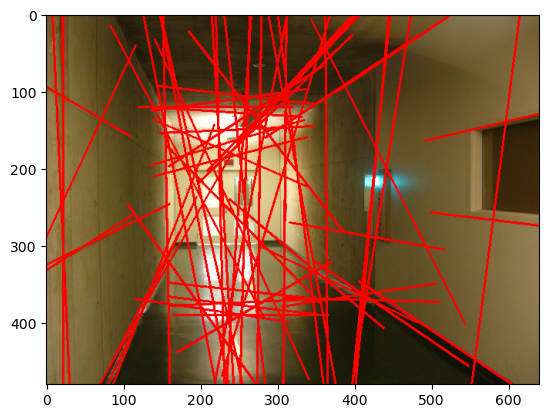

In [7]:


def detect_lines(image_path, min_line_length=5,visualize = False):
    """
    Detect lines in an image, return line coordinates, and visualize the lines.

    Args:
        image_path (str): Path to the input image.
        min_line_length (int): Minimum length threshold for detected lines.
        visualize(bool): Default False
    Returns:
        lines (list): List of line coordinates as tuples (x1, y1, x2, y2).
        is_infinite (list): List of boolean values indicating whether each line is at infinity.
        image_with_lines (ndarray): The input image with detected lines drawn on it.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a basic edge detection algorithm
    edges = cv2.Canny(gray, threshold1=50, threshold2=150)

    # Find contours using the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize lists to store line segments and their infinity status
    lines = []
    is_infinite = []
    
    if (visualize):
        # Create a copy of the original image to draw lines on
        image_with_lines = image.copy()

    # Iterate through the contours
    for contour in contours:
        if len(contour) >= min_line_length:
            # Fit a line to the contour using the least-squares method
            vx, vy, x, y = cv2.fitLine(contour, cv2.DIST_L2, 0, 0.01, 0.01)
            m = vy / vx if vx != 0 else np.inf  # Calculate slope and handle vertical lines

            if np.isinf(m):
                is_infinite.append(True)
            else:
                is_infinite.append(False)

            b = y - m * x
            x1 = int(x - 100)
            y1 = int(m * (x - 100) + b)
            x2 = int(x + 100)
            y2 = int(m * (x + 100) + b)

            lines.append((x1, y1, x2, y2))
            if visualize == True:
            # Draw the line on the image
                cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)
    if (visualize):
        return lines, is_infinite, image_with_lines
    else:
        return lines, is_infinite
# Example usage:
lines, is_infinite,image_with_lines = detect_lines("image.jpg",min_line_length=20,visualize = True)
'''
for i, line in enumerate(lines):
    print(f"Line {i + 1}: {line} (Is Infinite: {is_infinite[i]})")
    '''
#print(image_with_lines)
# Display the image with detected lines
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
plt.show()


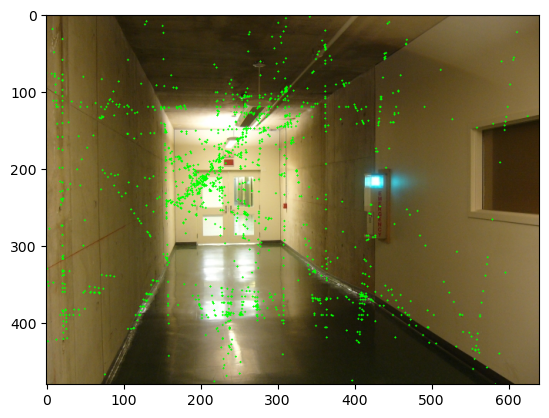

In [8]:
def find_intersections(lines, image_path, visualize=False):
    # Read the input image
    image = cv2.imread(image_path)
    image_with_intersections = image.copy()  # Create a copy of the original image

    height, width, _ = image.shape  # Get image dimensions

    # Initialize a list to store the intersection points
    intersections = []

    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            # Extract line coordinates
            x1, y1, x2, y2 = lines[i]
            x3, y3, x4, y4 = lines[j]

            # Calculate the intersection point
            det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)

            if det != 0:
                px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
                py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / det

                intersection_point = (px, py)

                
                intersections.append(intersection_point)

    if(visualize):
      # Draw circles at intersection points
      for intersection in intersections:
          x, y = map(int, intersection)
          cv2.circle(image_with_intersections, (x, y), 1, (0, 255, 0), -1)  # Green circles

      # Display the image with intersection points
      plt.imshow(cv2.cvtColor(image_with_intersections, cv2.COLOR_BGR2RGB))
      plt.show()

    return intersections

# Example usage:
intersections = find_intersections(lines, "image.jpg",True)


In [9]:
for i in range(1000):
  print(intersections[i])

(181.21621621621622, 266.022137715605)
(199.03819777834283, 228.49746296921788)
(122.33412887828162, 390.0)
(156.60349770642202, 317.8448967889908)
(118.81478646032701, 397.41007272926123)
(134.9872651734104, 363.35847182080926)
(72.4274170894129, 495.07996100269344)
(127.3571315343438, 379.4239290809545)
(225.01021385928718, 173.81266529124963)
(131.15684527124876, 371.42352679068733)
(134.8623149949879, 363.6215578748747)
(202.55332659835474, 221.0962620868812)
(113.87100089939612, 407.8193498650906)
(143.1116831862823, 346.25228515049105)
(185.81075235444166, 256.3482148919042)
(130.4557111993867, 372.89978395707016)
(316.18725059352425, -18.163105521038542)
(361.46622554863876, -113.4992387179881)
(215.17808219178082, 194.51449025951675)
(206.19016858492904, 213.43879076841574)
(259.19077825965, 101.84454225731979)
(224.20379863454428, 175.51059483480375)
(192.41818163546284, 242.436089923322)
(245.38512632884758, 130.91272396086868)
(207.02109971535717, 211.6892423078661)
(189.814

In [10]:
def calculate_line_length(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return length

def point_to_line_distance(x, y, x1, y1, x2, y2):
    # Calculate the distance from a point to a line defined by (x1, y1) and (x2, y2)
    line_length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    mask = (line_length != 0)
    distance = np.where(mask, np.abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / line_length, np.sqrt((x - x1) ** 2 + (y - y1) ** 2))
    return distance

In [11]:
'''
def vote_calc(lines,is_infinite,intersections):
  w1, w2, ta = 0.3, 0.7, 5
  vanishing_point_votes = []
  # Find the maximum length
  lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
  max_length = max(lengths)
  for point in intersections:
    votes = 0
    #print(point)
    x,y=point
    for line in lines:
      x1,y1,x2,y2 = line
      #print(x,y,x1,y1,x2,y2)
      distance = point_to_line_distance(x,y,x1,y1,x2,y2)
      #print(w1 * (1 - distance/ta))
      vote= (w1 * (1 - (distance / ta))) + w2 * (calculate_line_length(x1, y1, x2, y2) / max_length)
      votes=+vote
    vanishing_point_votes.append([x,y,votes])
    break
  return vanishing_point_votes
'''

'\ndef vote_calc(lines,is_infinite,intersections):\n  w1, w2, ta = 0.3, 0.7, 5\n  vanishing_point_votes = []\n  # Find the maximum length\n  lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]\n  max_length = max(lengths)\n  for point in intersections:\n    votes = 0\n    #print(point)\n    x,y=point\n    for line in lines:\n      x1,y1,x2,y2 = line\n      #print(x,y,x1,y1,x2,y2)\n      distance = point_to_line_distance(x,y,x1,y1,x2,y2)\n      #print(w1 * (1 - distance/ta))\n      vote= (w1 * (1 - (distance / ta))) + w2 * (calculate_line_length(x1, y1, x2, y2) / max_length)\n      votes=+vote\n    vanishing_point_votes.append([x,y,votes])\n    break\n  return vanishing_point_votes\n'

In [12]:
def calculate_vanishing_point_votes(lines, is_infinite, intersections, w1=0.3, w2=0.7, ta=5):
    # Calculate line lengths in a vectorized manner
    line_lengths = np.array([calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines])
    max_length = np.max(line_lengths)

    vanishing_point_votes = []

    for point in intersections:
        x, y = point
        x1, y1, x2, y2 = np.array(lines).T

        # Calculate distances in a vectorized manner
        distances = point_to_line_distance(x, y, x1, y1, x2, y2)
        distance_weights = w1 * (1 - distances / ta)
        length_weights = w2 * (line_lengths / max_length)

        votes = np.sum(distance_weights + length_weights)
        vanishing_point_votes.append([x, y, votes])

    return vanishing_point_votes


In [13]:
vanishing_point_votes = calculate_vanishing_point_votes(lines,is_infinite,intersections)
print(vanishing_point_votes[0])

[181.21621621621622, 266.022137715605, -336.7260887703836]


In [14]:
#print(vote_calc(lines,is_infinite,intersections))

In [15]:
print(intersections[0])

(181.21621621621622, 266.022137715605)


In [16]:
lengths = [calculate_line_length(x1, y1, x2, y2) for x1, y1, x2, y2 in lines]
print(max(lengths))

128308.15431998076


In [17]:

def calculate_angle(ai,aj):
    # Calculate the angle in degrees between two points with respect to the x-axis
		dx, dy, _ = np.array(ai) - np.array(aj)
		angle_degrees = np.degrees(np.arctan2(dy, dx))
		return angle_degrees

In [18]:
def calculate_distance_and_angle(ai,aj):
    x1,y1,_ = ai
    x2,y2,_ = aj
    distance=calculate_line_length(x1,y1,x2,y2)
    angle=calculate_angle(ai,aj)
    return distance, angle

In [19]:
def _vanishing_line_criterion_(ai,aj,td,talpha):

		# Use the distance function to get distance and angle
		distance, angle = calculate_distance_and_angle(ai, aj)
		#print(distance,angle)
		# Check if the distance and angle are below the thresholds
		if distance < td and angle < talpha:
			return True  # The vanishing point criterion is fulfilled
		return False  # The vanishing point criterion is not fulfilled

In [20]:
def calculate_slope(ai,aj):
    x1,y1,_ = ai
    x2,y2,_ = aj
    # Check for division by zero to avoid errors
    if x1 == x2:
        return "Undefined (Vertical Line)"
    else:
        return (y2 - y1) / (x2 - x1)

In [21]:
def orthoganality_camera_criterion(a1,ai,aj,point_difference_max,image_mid):
    #check if all angles are less than 90
    x1, y1,_ = a1
    x2, y2,_ = ai
    x3, y3,_ = aj

    # Calculate the lengths of the sides
    dAB = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    dBC = math.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    dCA = math.sqrt((x1 - x3)**2 + (y1 - y3)**2)

    # Calculate the angles in degrees
    angle1 = math.degrees(math.acos((dBC**2 + dCA**2 - dAB**2) / (2 * dBC * dCA)))
    angle2 = math.degrees(math.acos((dCA**2 + dAB**2 - dBC**2) / (2 * dCA * dAB)))
    angle3 = math.degrees(math.acos((dAB**2 + dBC**2 - dCA**2) / (2 * dAB * dBC)))


    centroid = ((a1[0] + ai[0] + aj[0]) / 3, (a1[1] + ai[1] + aj[1]) / 3)
    
    image_mid_x,image_mid_y=image_mid
    difference_principal_midpoint=calculate_line_length(centroid[0],centroid[1],image_mid_x,image_mid_y)
    if angle1 < 90 and angle2 < 90 and angle3 < 90 and difference_principal_midpoint < point_difference_max:
      #if np.isclose(slope(a1,ai) / slope(a1,aj), slope(a1,aj) / slope(ai,aj)):
      return True
    else:
      return False


In [22]:
print(vanishing_point_votes[0][2])

-336.7260887703836


Search step 

In [23]:
def search_step(image_path,lines,vanishing_point_votes,td=100,talpha=30,max_vote=-2000):
  img = cv2.imread(image_path)
  print(img.shape)
  height, width,_ = img.shape
  image_mid=(width//2,height//2)
  #print(image_mid)
  point_difference_max=(math.sqrt(width**2 + height**2)*.43)
  #print(point_difference_max)
  # Find the item with the maximum votes
  a1 = max(vanishing_point_votes, key=lambda item: item[2])
  #print(a1)
  # Create a list without the item with maximum votes
  eligible_votes = [item for item in vanishing_point_votes if item != a1]
  tries = 5000
  aiF= eligible_votes[0]
  ajF= eligible_votes[1]
  ai= eligible_votes[0]
  aj= eligible_votes[1]
  best_vote = a1[2] + ai[2] + aj[2]
  for i in range(tries):
    random_indices = random.sample(eligible_votes, 2)
    ai,aj= random_indices

    #print(a1,ai,aj)
    #print(_vanishing_line_criterion_(a1,ai,td,talpha),_vanishing_line_criterion_(ai,aj,td,talpha),_vanishing_line_criterion_(a1,aj,td,talpha))
    if _vanishing_line_criterion_(a1,ai,td,talpha) and _vanishing_line_criterion_(ai,aj,td,talpha) and _vanishing_line_criterion_(a1,aj,td,talpha):
      print("vanishing criterion passed")
      if orthoganality_camera_criterion(a1,ai,aj,point_difference_max,image_mid):
        print("orthoganality camera passed")
        final_vote = a1[2] + ai[2] + aj[2]
        if final_vote > best_vote:
          aiF=ai
          ajF=aj
        #print(a1,ai,aj)
        if final_vote > max_vote:
          #print(final_vote)
          #print(a1,ai,aj)
          aiF=ai
          ajF=aj
          tries=tries-1
          break
  if tries > 0:
    # Define the 2D points as a list of (x, y) coordinates
    ai=aiF
    aj=ajF
    

    return a1,ai,aj,True
  else:
    return 0,0,0,False
  pass

In [24]:
image_path="image.jpg"
a1,ai,aj,_ = search_step(image_path,lines,vanishing_point_votes)

(480, 640, 3)
vanishing criterion passed
orthoganality camera passed


Testing out the Search step and the final result by hand for a sample image

In [25]:
image = skimage.io.imread("image.jpg")

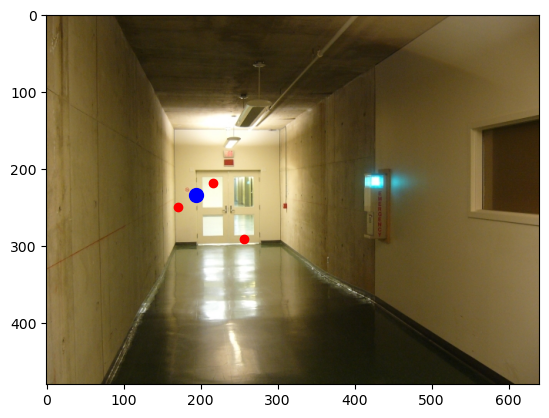

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the 2D points as a list of (x, y) coordinates
points = [(a1[0], a1[1]), (ai[0],ai[1]), (aj[0],aj[1])]

# Calculate the midpoint of the first two points
midpoint_x = (points[0][0] + points[1][0]) / 2
midpoint_y = (points[0][1] + points[1][1]) / 2
midpoint = (midpoint_x, midpoint_y)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Plot the 2D points on the image
for point in points:
    x, y = point
    ax.plot(x, y, 'ro')  # 'ro' for red circles

# Plot the midpoint as a blue circle
mid_x, mid_y = midpoint
ax.plot(mid_x, mid_y, 'bo', markersize=10)  # 'bo' for blue circle


# Show the image with the plotted points and midpoint
plt.show()


In [27]:
import zipfile

zip_file_path = "./data/YorkUrbanDB.zip"  # Replace with the path to your ZIP file
extracted_dir = "./data/"  # Replace with the directory where you want to extract the files

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)


In [28]:
'''import scipy.io
mat = scipy.io.loadmat('./data/YorkUrbanDB/P1040811/P1040811LinesAndVP.mat')
print(mat)'''

"import scipy.io\nmat = scipy.io.loadmat('./data/YorkUrbanDB/P1040811/P1040811LinesAndVP.mat')\nprint(mat)"

Data Loader for testing

In [29]:
%run ./dataloader_vp_.py


/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:68: RuntimeWarning: overflow encountered in scalar subtract
  det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:68: RuntimeWarning: overflow encountered in scalar multiply
  det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:70: RuntimeWarning: overflow encountered in scalar subtract
  px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
/home/anusha/Documents/projects/uni-heidelberg/3d reconstruction/computer-vision-3D-reconstruction/dataloader_vp_.py:70: RuntimeWarning: overflow encountered in scalar multiply
  px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / det
/home/anusha/Documents

[[(207.39980056311651, 214.36772641952052), (5006.512300339003, 227.4656625985343), (574.2212561524693, -15077.418585715039)], 'P1040811.jpg']
[[(0.9342806394316163, 3.6394316163410303), (0.9032070683909628, 0.5378030511480021), (14.056154282473058, 18.32161089052751)], 'P1020816.jpg']
[[(454.8141803524189, 285.20147880996376), (162.87518422532344, -11534.519579403546)], 'P1040815.jpg']
[[(-931.8559197324643, 277.43874916387955), (52.0668285127134, 6335.51578199791), (948.1809882407733, 291.50620592444426)], 'P1040779.jpg']
[[(22.256085177328256, 213.565451652015), (232.3894101199856, -9939.011189857232), (1231.8138900937108, 272.91067227887686)], 'P1080096.jpg']
[[(-1841.4142148808828, 256.54870613777723), (512.8218849155796, 279.47183280450224), (101.29204137141888, -1149.8991925446933)], 'P1040825.jpg']
[[(144.1139740221716, 170.56515615878197), (64.02900840544406, -2572.568452559876)], 'P1020171.jpg']
[[(-210.58465516345643, 61.50496597093238), (1226.8119535456826, 105.574456968148

In [30]:
#def _loss_function_()

In [31]:
'''import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ast
import os

# Define the CSV file name
csv_file = "data.csv"
filename_list=[]
# Read and parse the CSV file
with open(csv_file, newline='') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        # Parse the string representation of the points using ast.literal_eval
        points = ast.literal_eval(row[0])

        # Extract the filename
        filename = row[1]
        filename, _ = os.path.splitext(filename)
        filename = "./data/YorkUrbanDB" + "/" + filename + "/" + filename + ".jpg"
        filename_list.append(filename)
        # Create a new figure and axis for each image
        fig, ax = plt.subplots()

        # Load and display the image
        img = mpimg.imread(filename)
        ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])

        # Plot the points on the image
        for point in points:
            x, y = point
            # You can customize the appearance of the plotted points here
            ax.plot(x, y, 'ro', markersize=5)

        # Calculate the centroid of the points
        if points:
            x_coords, y_coords = zip(*points)
            centroid_x = sum(x_coords) / len(x_coords)
            centroid_y = sum(y_coords) / len(y_coords)

            # Plot the centroid
            ax.plot(centroid_x, centroid_y, 'bo', markersize=10)

        # Set the aspect ratio to 'equal' to prevent distortion in the plot
        ax.set_aspect('equal')

        ax.grid(True)

        # Show the plot for each image
        plt.show()'''


'import csv\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\nimport ast\nimport os\n\n# Define the CSV file name\ncsv_file = "data.csv"\nfilename_list=[]\n# Read and parse the CSV file\nwith open(csv_file, newline=\'\') as file:\n    csv_reader = csv.reader(file)\n    for row in csv_reader:\n        # Parse the string representation of the points using ast.literal_eval\n        points = ast.literal_eval(row[0])\n\n        # Extract the filename\n        filename = row[1]\n        filename, _ = os.path.splitext(filename)\n        filename = "./data/YorkUrbanDB" + "/" + filename + "/" + filename + ".jpg"\n        filename_list.append(filename)\n        # Create a new figure and axis for each image\n        fig, ax = plt.subplots()\n\n        # Load and display the image\n        img = mpimg.imread(filename)\n        ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]])\n\n        # Plot the points on the image\n        for point in points:\n            x, y = point

In [32]:
#print(filename_list)

In [33]:
img_path= "image.jpg"

In [36]:
def _sample_hypothsis_(img_path):
    # Example usage:
    lines, is_infinite= detect_lines("image.jpg",min_line_length=5,visualize = False)
    intersections = find_intersections(lines, img_path,False)
    vanishing_point_votes = calculate_vanishing_point_votes(lines,is_infinite,intersections)
    a1,ai,aj,success = search_step(image_path,lines,vanishing_point_votes)
    
    return a1,ai,aj,success

In [37]:
_sample_hypothsis_(img_path)

/tmp/ipykernel_90837/4260480984.py:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x1 = int(x - 100)
/tmp/ipykernel_90837/4260480984.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y1 = int(m * (x - 100) + b)
/tmp/ipykernel_90837/4260480984.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x2 = int(x + 100)
/tmp/ipykernel_90837/4260480984.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. E

TypeError: loop of ufunc does not support argument 0 of type int which has no callable sqrt method